<a href="https://colab.research.google.com/github/psa2001/computer_vision/blob/main/face_points_one_more_time_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Settings


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd

/root


In [ ]:
cd ..

/


In [ ]:
import os
from pathlib import Path
from IPython.display import clear_output


In [ ]:
"""
from zipfile import ZipFile


dataset_dir = Path('content/drive/My Drive/face_points_again_just_one_more_time')
os.chdir(dataset_dir) 
with ZipFile('public_tests.zip','r') as zipObj:
  zipObj.extractall()
"""

"\nfrom zipfile import ZipFile\n\n\ndataset_dir = Path('content/drive/My Drive/face_points_again_just_one_more_time')\nos.chdir(dataset_dir) \nwith ZipFile('public_tests.zip','r') as zipObj:\n  zipObj.extractall()\n"

In [ ]:
!unzip 'content/drive/My Drive/face_points_again_just_one_more_time/public_tests.zip' -d public_tests

In [ ]:
def read_csv(filename):
    res = {}
    with open(filename) as fhandle:
        next(fhandle)
        for line in fhandle:
            parts = line.rstrip('\n').split(',')
            coords = np.array([float(x) for x in parts[1:]], dtype='float64')
            res[parts[0]] = coords
    return res

#Load Data + Demonstration of fimal results


In [ ]:
from os.path import join
from skimage.io import imread
from tqdm import tqdm
import numpy as np
from skimage.transform import resize


def get_data(img_dir_whole, gt_dir_whole):
  set_of_images = []
  set_of_gt = []
  gt_all = read_csv(gt_dir_whole)


  for cur_pic in tqdm(sorted(os.listdir(img_dir_whole))):     
    image = (imread(join(img_dir_whole, cur_pic)).astype('float64'))
    gt_cur = np.array(gt_all[cur_pic], dtype = np.float64)

    gt_cur[::2] *= (100. / image.shape[1])
    gt_cur[1::2] *= (100. / image.shape[0])
    set_of_gt.append(gt_cur)

    if(np.size(np.shape(image)) == 3 and np.shape(image)[2] == 3):
      image = 0.2125 * image[:, :, 0] + 0.7154 * image[:, :, 1] + 0.0721 * image[:, :, 2]

    image = resize(image, (100, 100))
    set_of_images.append(image)

  return (set_of_images), (set_of_gt)

In [ ]:
img_dir_whole = 'public_tests/00_test_img_input/train/images'
gt_dir_whole = 'public_tests/00_test_img_input/train/gt.csv'

x, y = get_data(img_dir_whole, gt_dir_whole)

100%|██████████| 6000/6000 [02:26<00:00, 40.93it/s] 


In [ ]:
x = np.array(x)
y = np.array(y)

In [ ]:
x.shape, y.shape

((6000, 100, 100), (6000, 28))

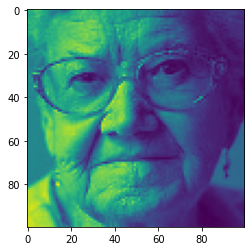

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

i = np.random.randint(6000)
ax.imshow(x[i])

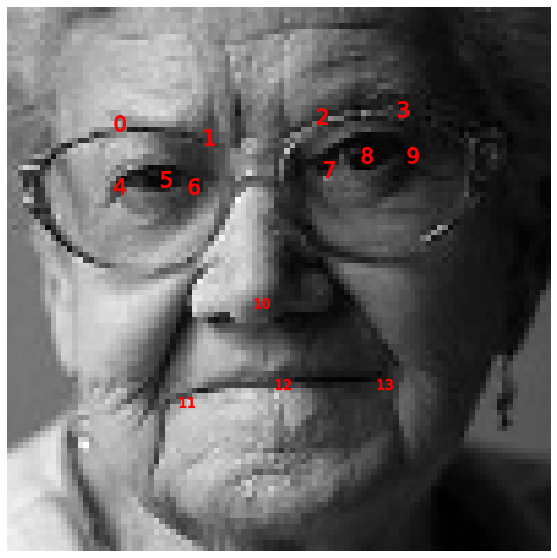

In [ ]:
img_size = 100

def show_points(image, face_points):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 10))
    plt.imshow(image, cmap = 'gray')
    plt.axis('off')
    for i, x in enumerate(range(0, face_points.size, 2)):
        plt.scatter(face_points[x], face_points[x + 1], s=256,
                    marker='$' + str(i) + '$', edgecolors='face', color='r')
    plt.show()
    
show_points(x[i], y[i])

#Image normalization
(max = 255; min = 0)

In [ ]:
x_norm = x / 255.

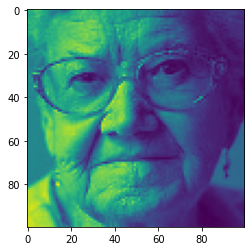

In [ ]:
fig, ax = plt.subplots()

ax.imshow(x_norm[i])

#Augmentation:Rotation + shuffling function 

In [ ]:
def shuffle(x, y):
    p = np.random.permutation(len(x)).astype(int)
    print(p)
    x = x[p,]
    y = y[p,]
    return x, y

In [ ]:
import skimage
import skimage.io
import skimage.transform

def augmentate(input_pair):
    img = input_pair[0]
    gt  = input_pair[1]



    shift = 49.5
    modes = ['reflect', 'constant']

    angle = np.random.randint(-90, 90)
    angle_rad = np.pi * angle / 180
    img = skimage.transform.rotate(img, angle, mode=modes[np.random.randint(2)], cval=np.mean(img)) 
    gt = gt.reshape((-1, 2)).T - shift
    gt = (np.asarray([[np.cos(angle_rad), np.sin(angle_rad)], \
                    [-np.sin(angle_rad), np.cos(angle_rad)]]) @ gt).T.reshape(28)

    gt += shift
 
    return (img, gt)

#Model + root_mean_squared_error + Datagenerator + compiling

In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow as tf

first = 16
dense_neuron = 500

model = tf.keras.models.Sequential([ 
  #first conv
  tf.keras.layers.Conv2D(first, (3, 3), input_shape = (100, 100, 1)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(2, 2),   



  tf.keras.layers.Conv2D(first * 2, (3, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(2, 2),   
  


  tf.keras.layers.Conv2D(first * 4, (3, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(2, 2),   
  

  tf.keras.layers.Conv2D(first * 8, (3, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(2, 2),   
 
  
  tf.keras.layers.Conv2D(first * 16, (3, 3)),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.MaxPooling2D(2, 2),

  #tf.keras.layers.Dropout(0.2),
  # Flatten the results to feed into a DNN
  
  tf.keras.layers.Flatten(),
  #Dense layers
  tf.keras.layers.Dense(dense_neuron),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(dense_neuron),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  tf.keras.layers.Dense(dense_neuron),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.ReLU(),
  #Output
  tf.keras.layers.Dense(28)
  ])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 98, 98, 16)        160       
_________________________________________________________________
batch_normalization_11 (Batc (None, 98, 98, 16)        64        
_________________________________________________________________
re_lu_16 (ReLU)              (None, 98, 98, 16)        0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 49, 49, 16)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 47, 47, 32)        4640      
_________________________________________________________________
batch_normalization_12 (Batc (None, 47, 47, 32)        128       
_________________________________________________________________
re_lu_17 (ReLU)              (None, 47, 47, 32)       

In [ ]:
from tensorflow.keras.optimizers import SGD, Adam
from keras.models import load_model
 

 
def root_mean_squared_error(y_true, y_pred):
  import tensorflow.keras.backend as K
  #print('y_true, y_pred', y_true.shape, y_pred.shape)
  b = K.reshape(y_true, (-1, 28))
  c = K.reshape(y_pred, (-1, 28))
  a = (K.square(b - c))
  summing = K.sum(a, axis = 1)
  meaning = K.mean(summing, axis = 0)
  return meaning
 
 
chkpt = tf.keras.callbacks.ModelCheckpoint("content/drive/My Drive/face_points_again_just_one_more_time/211120_try2_500neurons_5pooling.hdf5", 
                        monitor='val_loss', 
                        verbose=1, 
                        save_best_only=True, 
                        mode='auto')
 
 
model.compile(
    loss = 'mse',
    optimizer=Adam(),
)

In [ ]:
from IPython.display import clear_output


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, imgs, gts, batch_size=10, target_size=(100, 100, 1)):
        self.target_size = target_size
        self.batch_size = batch_size
        self.imgs = imgs
        self.gts = gts
        self.iter = 0
        #print(images)

    def __len__(self):
        return len(self.imgs) // self.batch_size

    def __getitem__(self, idx):
        x = self.imgs[idx * self.batch_size:(idx + 1) * self.batch_size]
        y = self.gts[idx * self.batch_size:(idx + 1) * self.batch_size]
        x, y = list(zip(*map(augmentate, zip(x, y))))
        
        x = np.asarray(x)
        x = x[:,:,:,np.newaxis]
        y = np.asarray(y)
        return x, y
    
    def on_epoch_end(self):
        self.iter = (1 + self.iter) % 10
        if(self.iter == 0):
          clear_output()
        self.imgs, self.gts = shuffle(self.imgs, self.gts)

#train/val


In [ ]:
x_shuffled, y_shuffled = shuffle(x_norm , y)

[2077 1768  851 ... 5716 3097 4502]


In [ ]:
volume_train = 4000
x_train = x_shuffled[:volume_train]
y_train = y_shuffled[:volume_train]

x_valid = x_shuffled[volume_train:]
x_valid = x_valid[:,:,:,np.newaxis]
y_valid = y_shuffled[volume_train:]

#Training

In [ ]:
model.fit_generator(
    DataGenerator(x_train, y_train, batch_size = 10),
    epochs = 2500, 
    validation_data = (x_valid, y_valid),
    callbacks = [chkpt]
)

[3237  990 1300 ...  611 2145  469]


In [ ]:
model.evaluate(x_valid, y_valid)

63/63 [==============================] - 0s 4ms/step - loss: 4.7237 - root_mean_squared_error: 132.0512


[4.723742485046387, 132.05117797851562]

#Evaluation(mark/no picture)

In [ ]:
cd

/root


In [ ]:
cd ..

/


In [ ]:
import os
from pathlib import Path


In [ ]:


dataset_dir = Path('content/drive/My Drive/face_points_again_just_one_more_time')
os.chdir(dataset_dir) 

In [ ]:
ls

00_test_img_gt/     211120_try1.hdf5  detection.py           public_tests.zip
00_test_img_input/  build.sh          facepoints_model.hdf5  run.py


In [ ]:
!chmod +x run.py

In [ ]:
model = load_model('facepoints_model.hdf5', compile = False)

model.compile(
    loss = 'mse',
    optimizer=Adam(),
)


In [ ]:
model.save('facepoints_model.hdf5')

In [ ]:
!./'content/drive/My Drive/face_points_again_just_one_more_time/run.py' public_tests

2020-11-21 11:16:00.043514: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
  0% 0/6000 [00:00<?, ?it/s]
2020-11-21 11:16:01.777788: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-21 11:16:01.782272: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-21 11:16:01.782868: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-11-21 11:16:01.782907: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-21 11:16:01.784708: I tensorflow/str